## Project Title: Explainable AI for Healthcare Prediction Models: Diabetes Prediction

**Introduction: I have decided to work on a project focused on implementing Explainable AI (XAI) techniques to enhance trust and transparency in healthcare prediction models. The goal is to develop a predictive model that can effectively identify the risk of diabetes in patients while providing interpretable and actionable insights into the model’s decision-making process.**

**Dataset: For this project, I have chosen the Pima Indians Diabetes Dataset from the UCI Machine Learning Repository (available on Kaggle). This dataset is ideal because:**

**It addresses a critical healthcare issue—diabetes prediction.
It contains a mix of numerical and categorical features relevant to healthcare.
It is well-documented and widely used in machine learning research, ensuring robustness and ease of implementation.**

In [1]:
!pip install shap

In [2]:
!pip install lime

In [3]:
#Load the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import shap


from lime import lime_tabular
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc, confusion_matrix


In [4]:
# load the dataset
# Load the dataset (update the path to your downloaded dataset)
data = pd.read_csv("diabetes.csv")

# Display the first few rows of the dataset
print("Dataset Preview:")
print(data.head())

# Display dataset information
print("\nDataset Information:")
print(data.info())

# Check for missing values
print("\nMissing Values in the Dataset:")
print(data.isnull().sum())

# Statistical summary of the dataset
print("\nSummary:")
print(data.describe())

Dataset Preview:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int


Plotting distributions of numerical features:


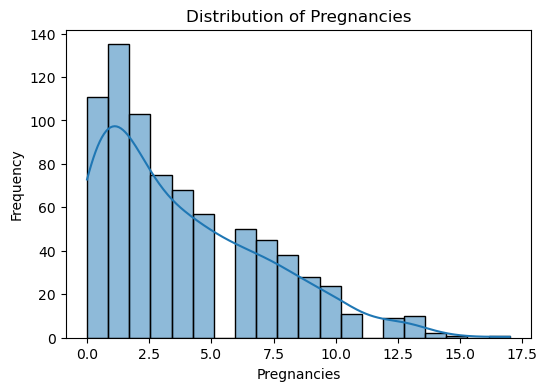

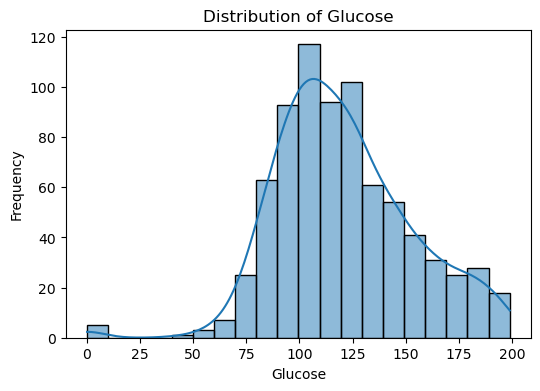

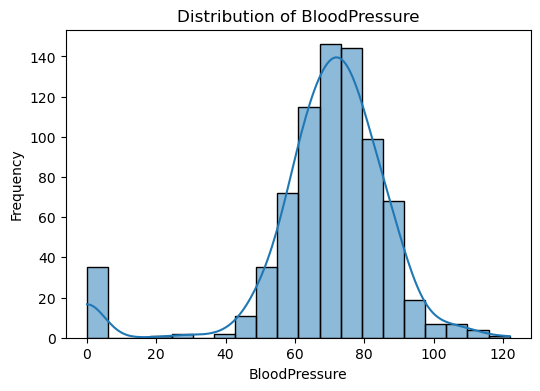

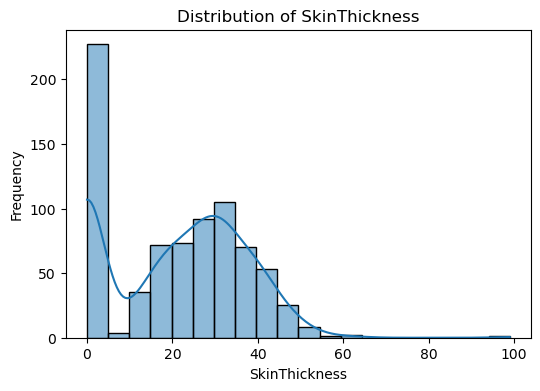

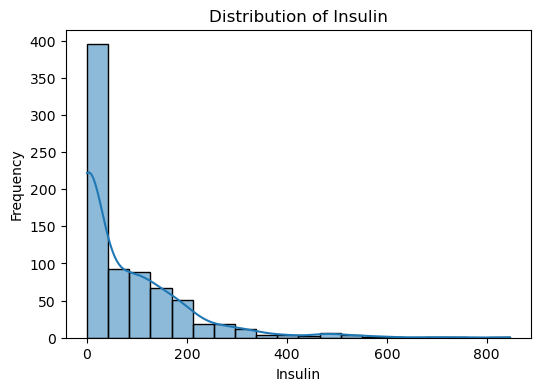

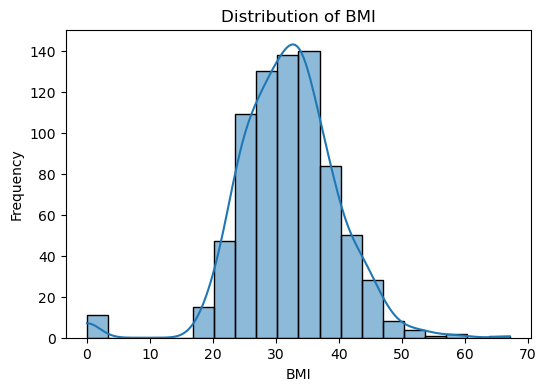

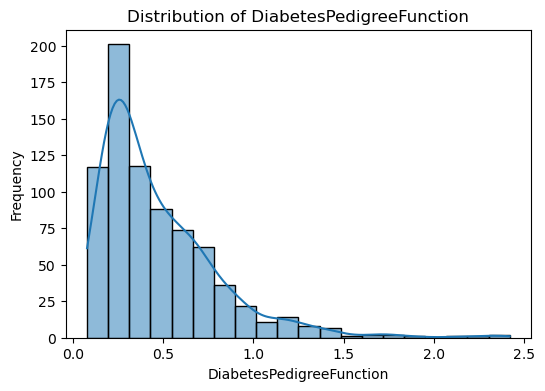

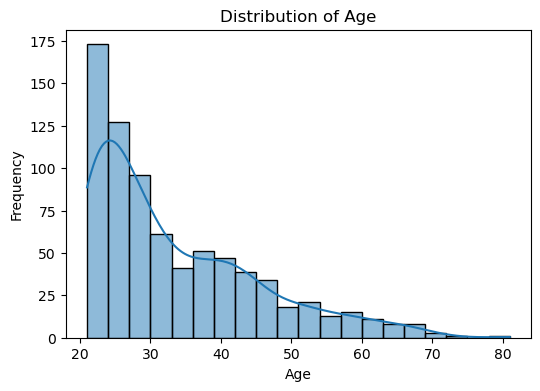

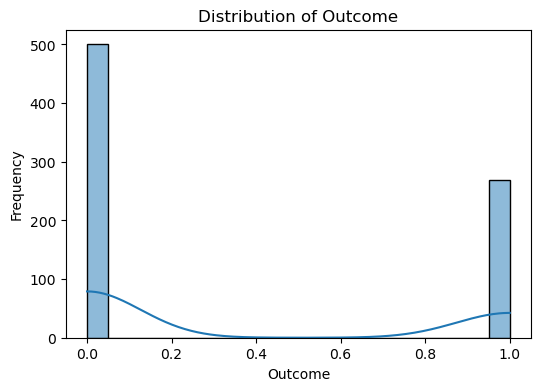


Feature Correlation Heatmap:


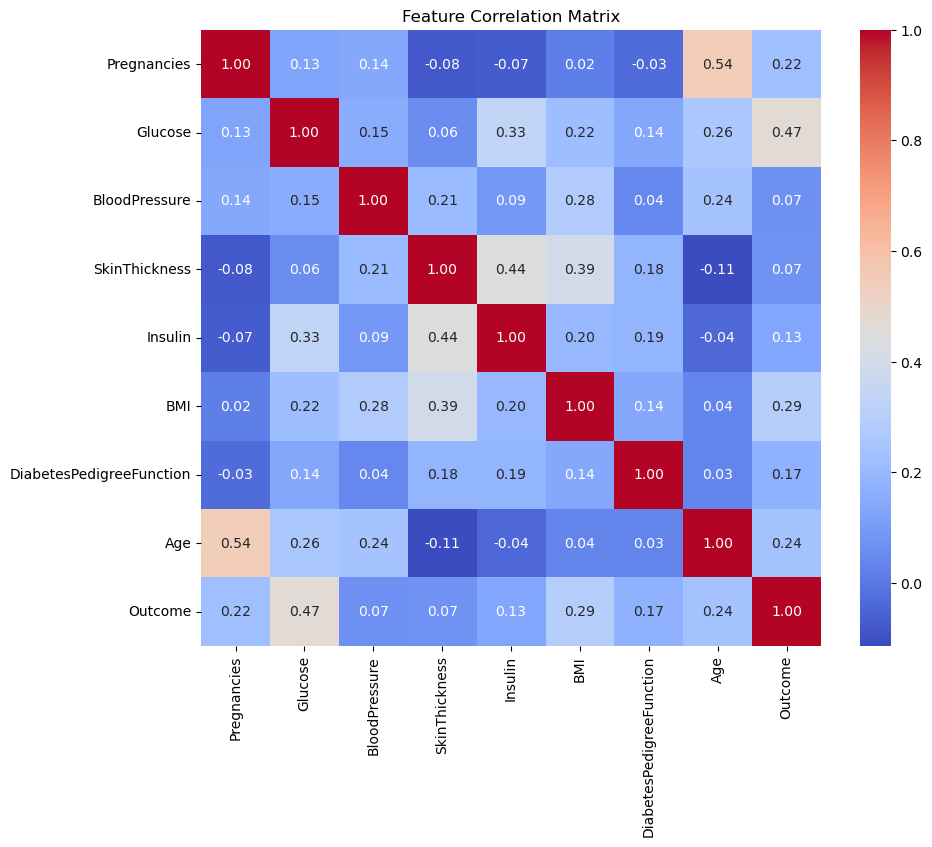


Histograms for all columns:


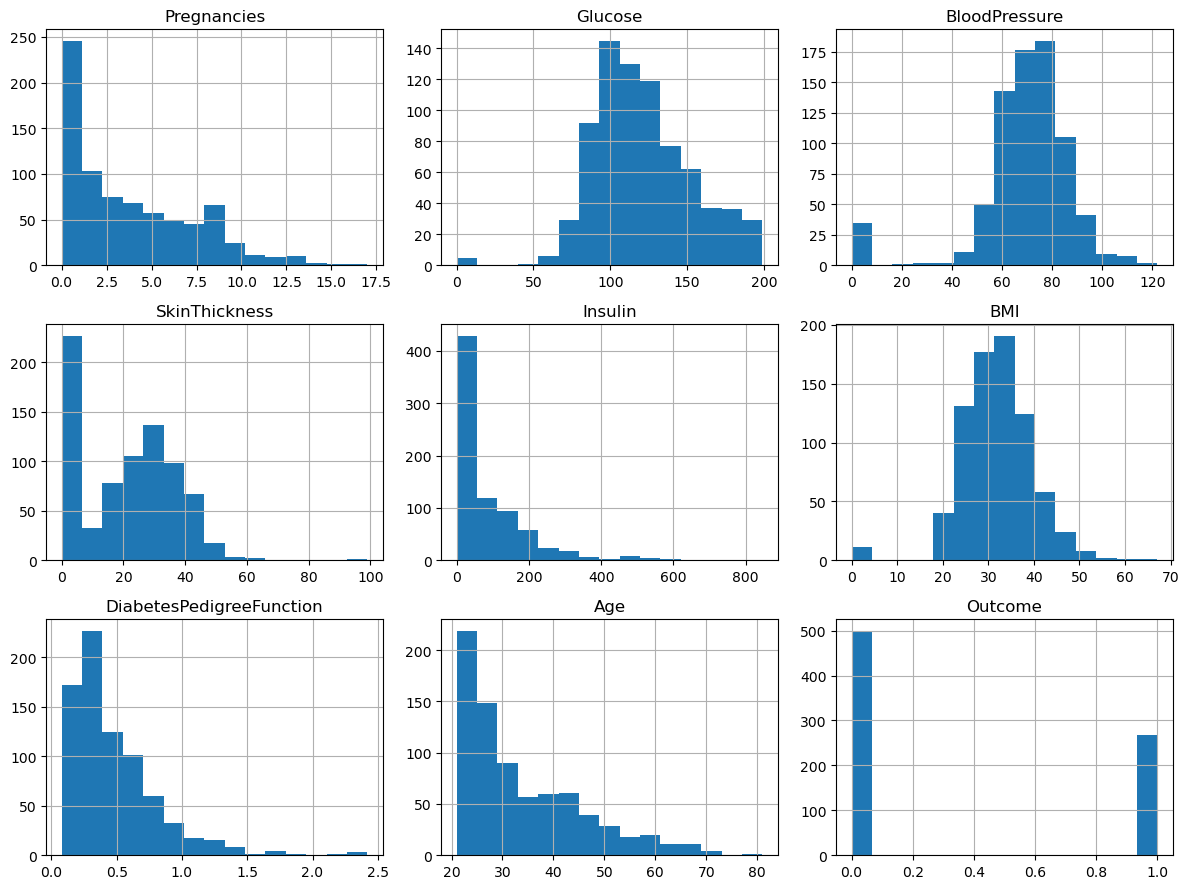

In [5]:
# explanatory data analysis

# Plot distributions of numerical features
print("\nPlotting distributions of numerical features:")
for column in data.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(data[column], kde=True, bins=20)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

# Plot correlations as a heatmap
print("\nFeature Correlation Heatmap:")
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

# Plot histograms for all columns
print("\nHistograms for all columns:")
num_columns = len(data.columns)
rows = math.ceil(num_columns / 3)
data.hist(bins=15, figsize=(12, rows * 3), layout=(rows, 3))
plt.tight_layout()
plt.show()

In [6]:
# Data cleaning
# Step 1: Handle Missing/Invalid Values
invalid_zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in invalid_zero_cols:
    median_value = data[col].replace(0, np.nan).median()
    data[col] = data[col].replace(0, median_value)
print("Handled missing/invalid values.")

# Step 2: Detect and Handle Outliers using the IQR method
for col in data.select_dtypes(include=['float64', 'int64']).columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data[col] = np.where(data[col] < lower_bound, lower_bound, data[col])
    data[col] = np.where(data[col] > upper_bound, upper_bound, data[col])
print("Detected and handled outliers.")

# Step 3: Normalize/Scale Numerical Features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns.drop('Outcome')
data[numerical_features] = scaler.fit_transform(data[numerical_features])
print("Normalized/scaled numerical features.")

# Step 4: Encode Categorical Features (if applicable)
categorical_columns = data.select_dtypes(include=['object']).columns
if len(categorical_columns) > 0:
    data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)
    print("Encoded categorical features.")
else:
    print("No categorical features to encode.")

# Display the final dataset for review
print("\nCleaned Dataset Preview:")
data.head()

Handled missing/invalid values.
Detected and handled outliers.
Normalized/scaled numerical features.
No categorical features to encode.

Cleaned Dataset Preview:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.444444,0.670968,0.50000,0.732143,0.527174,0.480499,0.489305,0.637363,1.0
1,0.074074,0.264516,0.40625,0.517857,0.527174,0.262090,0.243316,0.219780,0.0
2,0.592593,0.896774,0.37500,0.517857,0.527174,0.159126,0.529412,0.241758,1.0
3,0.074074,0.290323,0.40625,0.303571,0.000000,0.308892,0.079323,0.000000,0.0
4,0.000000,0.600000,0.00000,0.732143,1.000000,0.776911,1.000000,0.263736,1.0


In [7]:
# Feature Transformation
# Log-transform skewed features, such as Insulin, if applicable
if 'Insulin' in data.columns:
    data['Log_Insulin'] = np.log1p(data['Insulin'])
    print("Log-transformed Insulin to reduce skewness.")

# Feature Interaction
# Adding an interaction term between BMI and Glucose
data['BMI_Glucose_Interaction'] = data['BMI'] * data['Glucose']
print("Added BMI_Glucose_Interaction as a product of BMI and Glucose.")

# Feature Selection
# Compute correlations only for numeric columns
numeric_data = data.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_data.corr()
important_features = correlation_matrix['Outcome'].abs().sort_values(ascending=False).index[1:6]
print(f"Identified important features: {important_features.tolist()}")

# Derived Features
# Example: Adding an Age category feature
data['Age_Category'] = pd.cut(data['Age'], bins=[0, 25, 50, 75], labels=['Young', 'Middle-aged', 'Senior'])
data = pd.get_dummies(data, columns=['Age_Category'], drop_first=True)
print("Added and encoded Age_Category based on Age.")

# Step 6: Save the Dataset
output_file = "cleaned_dataset.csv"
data.to_csv(output_file, index=False)
print(f"Dataset saved to {output_file}.")

# Final Dataset Overview
print("\nTransformed Dataset Preview:")
print(data.head())

Log-transformed Insulin to reduce skewness.
Added BMI_Glucose_Interaction as a product of BMI and Glucose.
Identified important features: ['BMI_Glucose_Interaction', 'Glucose', 'BMI', 'Log_Insulin', 'Insulin']
Added and encoded Age_Category based on Age.
Dataset saved to cleaned_dataset.csv.

Transformed Dataset Preview:
   Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0     0.444444  0.670968        0.50000       0.732143  0.527174  0.480499   
1     0.074074  0.264516        0.40625       0.517857  0.527174  0.262090   
2     0.592593  0.896774        0.37500       0.517857  0.527174  0.159126   
3     0.074074  0.290323        0.40625       0.303571  0.000000  0.308892   
4     0.000000  0.600000        0.00000       0.732143  1.000000  0.776911   

   DiabetesPedigreeFunction       Age  Outcome  Log_Insulin  \
0                  0.489305  0.637363      1.0     0.423419   
1                  0.243316  0.219780      0.0     0.423419   
2                  

Dataset split into training and testing sets.
Logistic Regression model trained.

Logistic Regression Evaluation:
              precision    recall  f1-score   support

         0.0       0.80      0.82      0.81        99
         1.0       0.66      0.64      0.65        55

    accuracy                           0.75       154
   macro avg       0.73      0.73      0.73       154
weighted avg       0.75      0.75      0.75       154

ROC-AUC Score: 0.83
Confusion Matrix:
[[81 18]
 [20 35]]


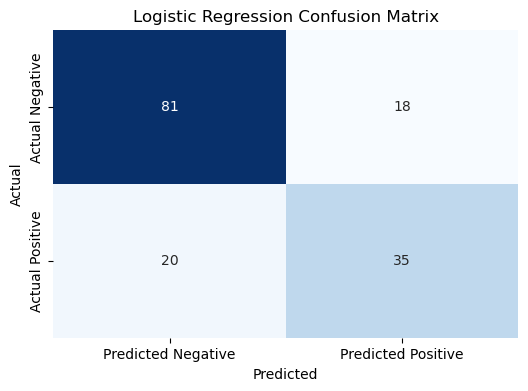

In [8]:
# Split the Dataset
X = data.drop('Outcome', axis=1)
y = data['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Dataset split into training and testing sets.")

# Logistic Regression
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)
log_reg_pred = log_reg.predict(X_test)
log_reg_prob = log_reg.predict_proba(X_test)[:, 1]
print("Logistic Regression model trained.")

# Logistic Regression Evaluation
print("\nLogistic Regression Evaluation:")
print(classification_report(y_test, log_reg_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, log_reg_prob):.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, log_reg_pred))

# Plot Confusion Matrix for Logistic Regression
log_reg_cm = confusion_matrix(y_test, log_reg_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(log_reg_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Random Forest model trained.

Random Forest Evaluation:
              precision    recall  f1-score   support

         0.0       0.83      0.81      0.82        99
         1.0       0.67      0.71      0.69        55

    accuracy                           0.77       154
   macro avg       0.75      0.76      0.76       154
weighted avg       0.78      0.77      0.77       154

ROC-AUC Score: 0.83
Confusion Matrix:
[[80 19]
 [16 39]]


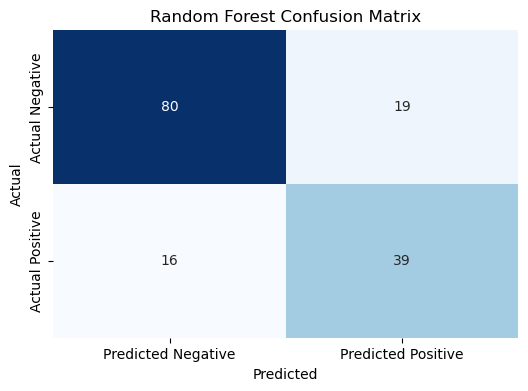

In [9]:
# Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
rf_prob = rf_clf.predict_proba(X_test)[:, 1]
print("Random Forest model trained.")

# Random Forest Evaluation
print("\nRandom Forest Evaluation:")
print(classification_report(y_test, rf_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, rf_prob):.2f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, rf_pred))

# Plot Confusion Matrix for Random Forest Classifier
rf_cm = confusion_matrix(y_test, rf_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

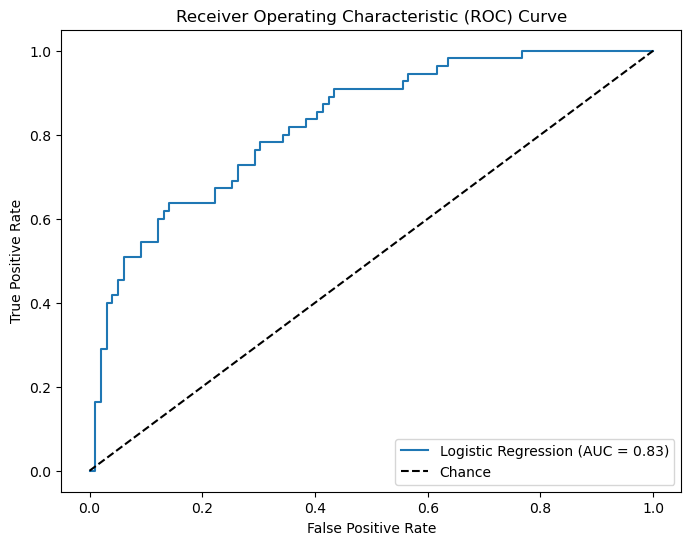

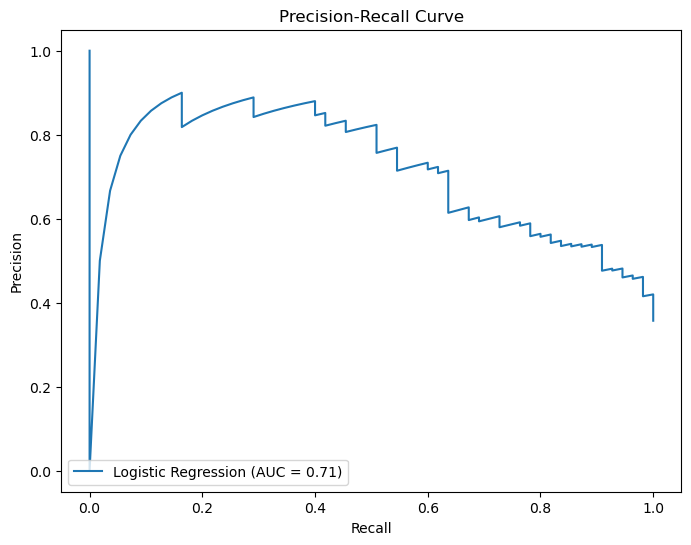

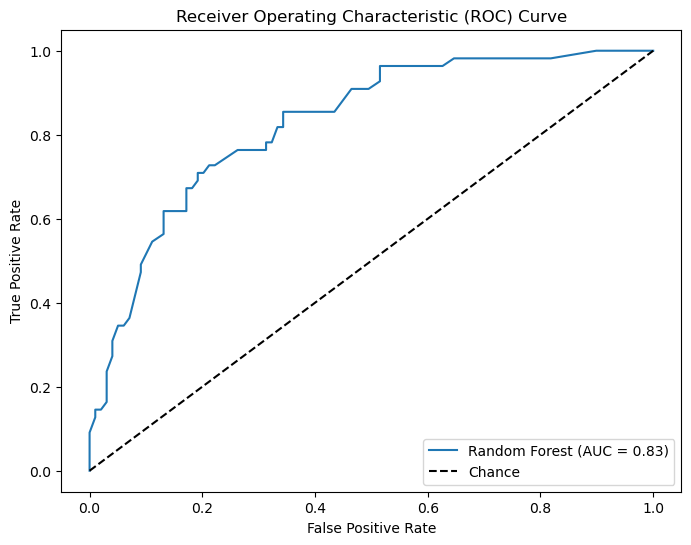

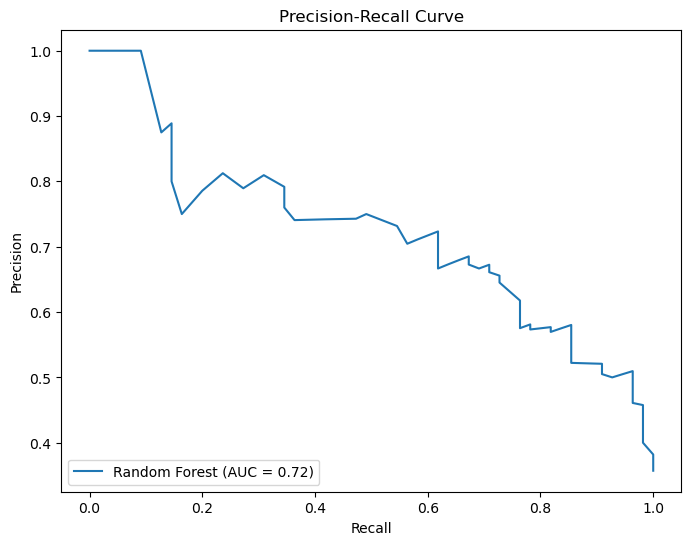

In [10]:
# Visualization Functions
def plot_roc_curve(y_test, y_prob, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label="Chance")
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

def plot_precision_recall_curve(y_test, y_prob, model_name):
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'{model_name} (AUC = {pr_auc:.2f})')
    plt.title('Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc="lower left")
    plt.show()

# Plot ROC and Precision-Recall Curves
plot_roc_curve(y_test, log_reg_prob, "Logistic Regression")
plot_precision_recall_curve(y_test, log_reg_prob, "Logistic Regression")

plot_roc_curve(y_test, rf_prob, "Random Forest")
plot_precision_recall_curve(y_test, rf_prob, "Random Forest")


Tuned Random Forest Evaluation:
              precision    recall  f1-score   support

         0.0       0.81      0.84      0.83        99
         1.0       0.69      0.65      0.67        55

    accuracy                           0.77       154
   macro avg       0.75      0.75      0.75       154
weighted avg       0.77      0.77      0.77       154

ROC-AUC Score: 0.84


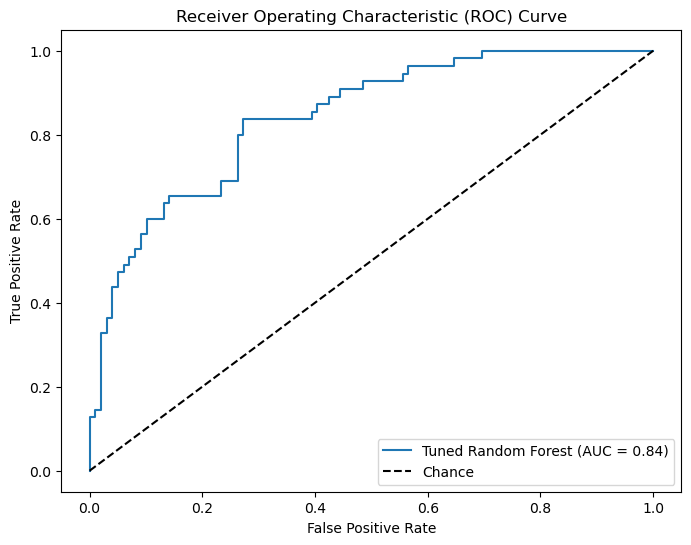

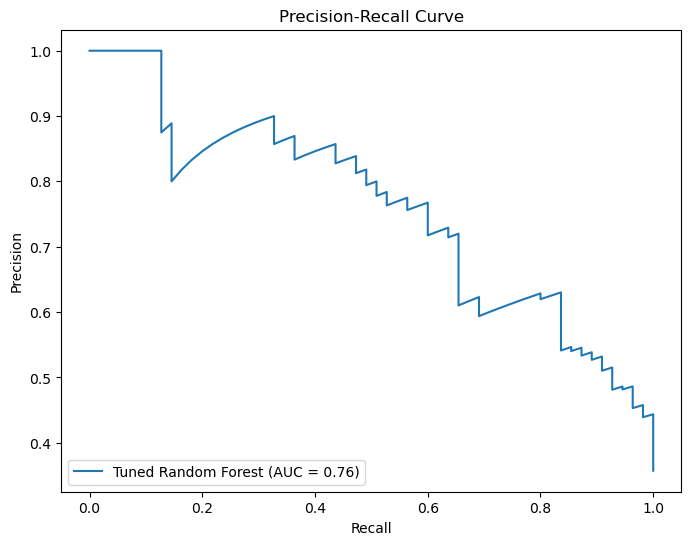

In [11]:
# Hyperparameter Tuning for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, scoring='roc_auc', cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
best_rf_pred = best_rf.predict(X_test)
best_rf_prob = best_rf.predict_proba(X_test)[:, 1]

print("\nTuned Random Forest Evaluation:")
print(classification_report(y_test, best_rf_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, best_rf_prob):.2f}")

# Visualize performance metrics for the tuned Random Forest
plot_roc_curve(y_test, best_rf_prob, "Tuned Random Forest")
plot_precision_recall_curve(y_test, best_rf_prob, "Tuned Random Forest")


SHAP Force Plot for a Single Prediction (Static with Matplotlib):


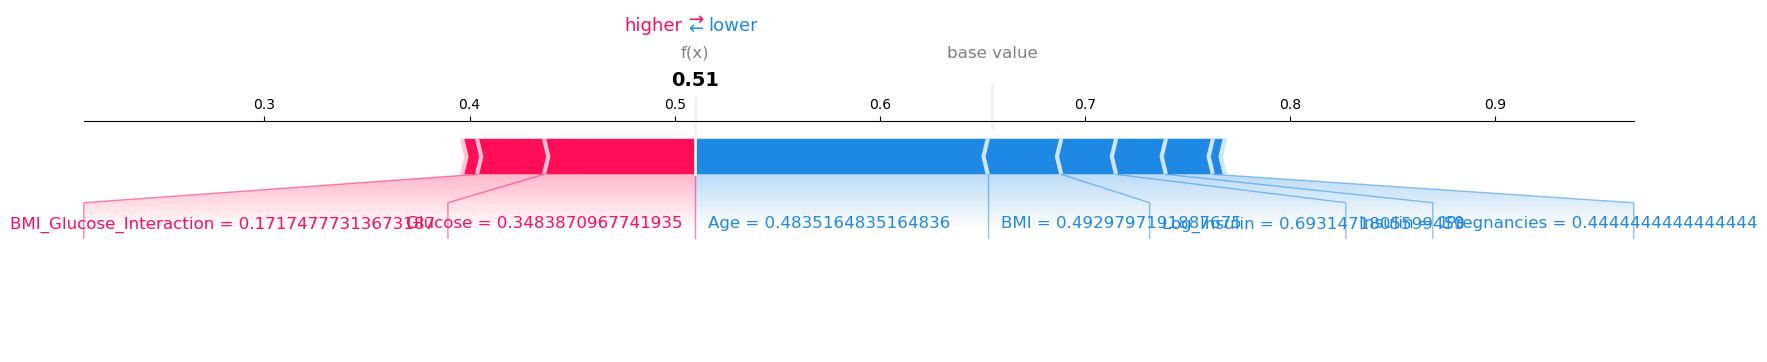

Shape of shap_values.values: (154, 12, 2)


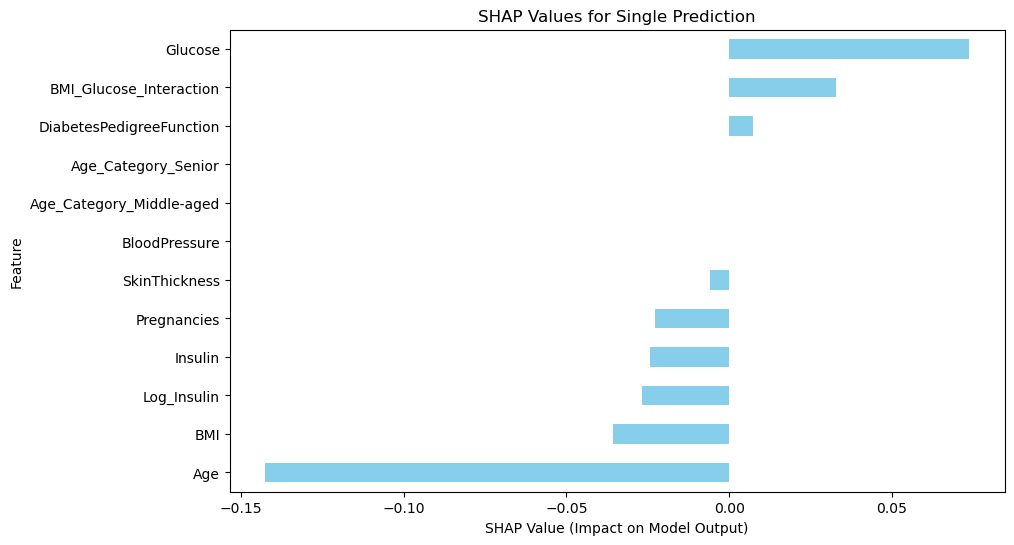

In [12]:
# Apply SHAP for Explainability
if isinstance(X_test, np.ndarray):
    X_test = pd.DataFrame(X_test, columns=X_train.columns)

explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer(X_test)

# SHAP Force Plot for a Single Prediction
print("\nSHAP Force Plot for a Single Prediction (Static with Matplotlib):")
shap.force_plot(explainer.expected_value[0], shap_values.values[0, :, 0], X_test.iloc[0, :], matplotlib=True)

# Inspect SHAP Values Structure
print("Shape of shap_values.values:", shap_values.values.shape)

# Feature Contributions for Single Prediction
shap_values_output_0 = shap_values.values[:, :, 0]
feature_contributions = pd.Series(shap_values_output_0[0], index=X_test.columns)

# Bar Chart for Feature Contributions
plt.figure(figsize=(10, 6))
feature_contributions.sort_values().plot(kind="barh", color="skyblue")
plt.title("SHAP Values for Single Prediction")
plt.xlabel("SHAP Value (Impact on Model Output)")
plt.ylabel("Feature")
plt.show()

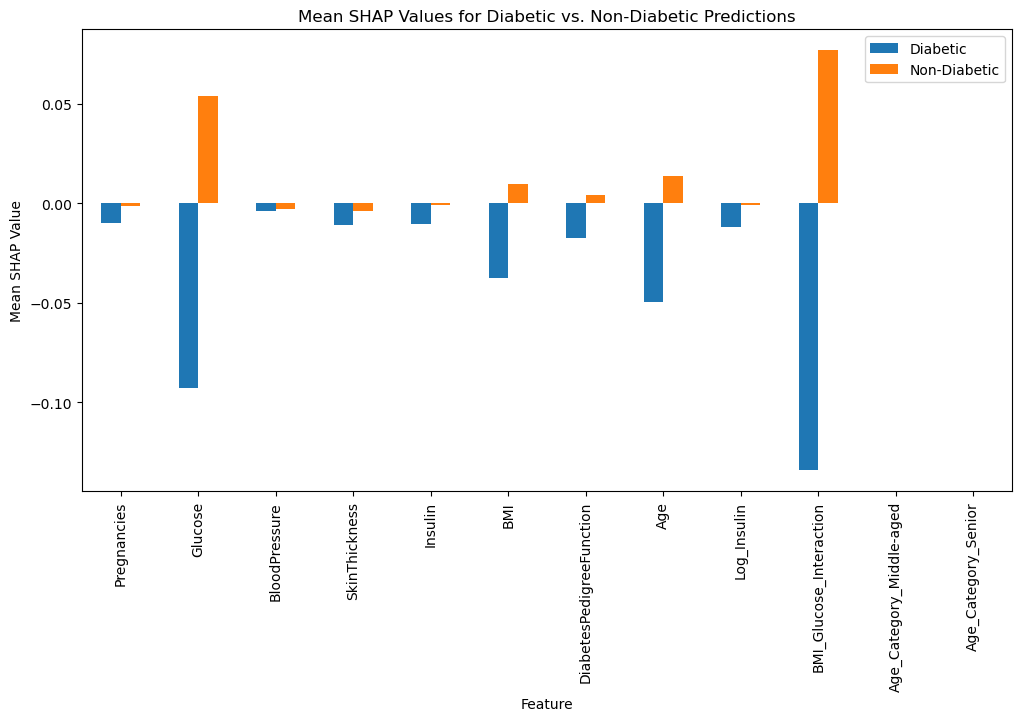

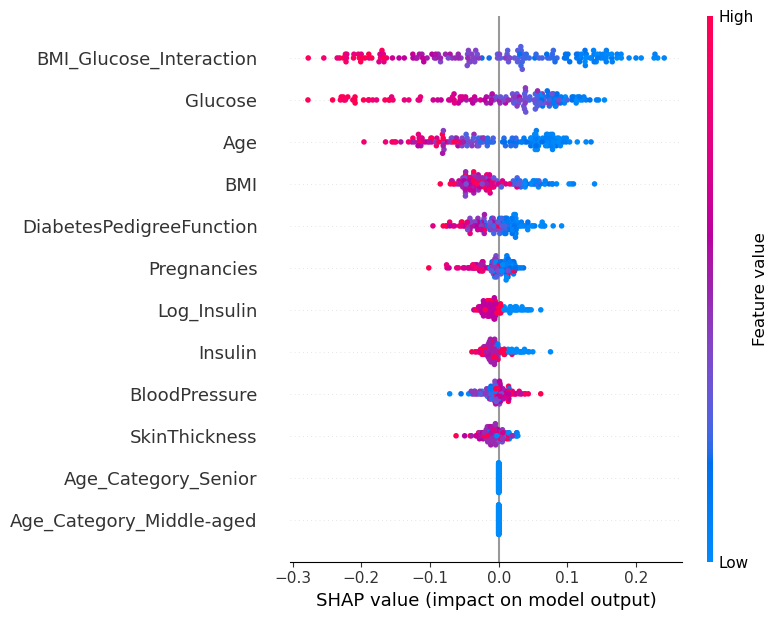

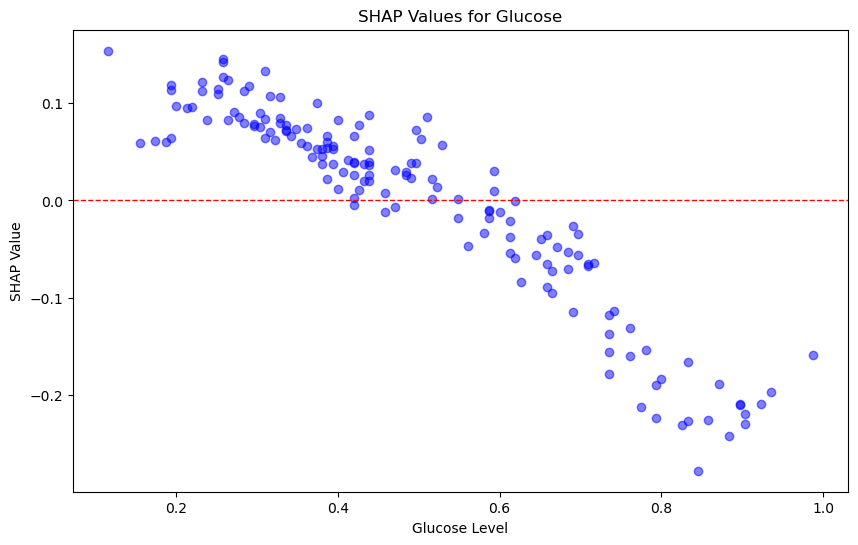

Mean SHAP value for Glucose (Diabetic Predictions): -0.09281277887063202
Mean SHAP value for Glucose (Non-Diabetic Predictions): 0.05383819529880002


In [13]:
# Convert X_test to DataFrame if it's in a different format
if isinstance(X_test, np.ndarray):
    X_test = pd.DataFrame(X_test, columns=X_train.columns)

# Create SHAP Explainer
explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer(X_test)

# Task 1: Comparative Analysis (Diabetic vs. Non-Diabetic Predictions)
# Extract predictions
predictions = rf_clf.predict(X_test)

# Split SHAP values by diabetic (1) and non-diabetic (0) predictions
shap_values_diabetic = shap_values.values[predictions == 1, :, 0]
shap_values_non_diabetic = shap_values.values[predictions == 0, :, 0]

# Calculate mean SHAP values for each feature
mean_shap_diabetic = pd.DataFrame(shap_values_diabetic, columns=X_test.columns).mean()
mean_shap_non_diabetic = pd.DataFrame(shap_values_non_diabetic, columns=X_test.columns).mean()

# Plot comparison
mean_shap_df = pd.DataFrame({
    "Diabetic": mean_shap_diabetic,
    "Non-Diabetic": mean_shap_non_diabetic
})
mean_shap_df.plot(kind="bar", figsize=(12, 6))
plt.title("Mean SHAP Values for Diabetic vs. Non-Diabetic Predictions")
plt.ylabel("Mean SHAP Value")
plt.xlabel("Feature")
plt.show()

# Task 2: Global Insights (SHAP Summary Plot)
shap.summary_plot(shap_values.values[:, :, 0], X_test, feature_names=X_test.columns)

# Task 3: Model Validation (Confirm with Domain Knowledge)
# Analyze the SHAP values for "Glucose" specifically
glucose_shap_values = shap_values.values[:, X_test.columns.get_loc("Glucose"), 0]

# Create a scatter plot of SHAP values for Glucose against its feature values
plt.figure(figsize=(10, 6))
plt.scatter(X_test["Glucose"], glucose_shap_values, alpha=0.5, color='blue')
plt.title("SHAP Values for Glucose")
plt.xlabel("Glucose Level")
plt.ylabel("SHAP Value")
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.show()

# Analyze and print observations
print("Mean SHAP value for Glucose (Diabetic Predictions):", mean_shap_diabetic["Glucose"])
print("Mean SHAP value for Glucose (Non-Diabetic Predictions):", mean_shap_non_diabetic["Glucose"])


In [14]:
# LIME Explanation
lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train.values, 
    feature_names=X_train.columns,
    class_names=['No Diabetes', 'Diabetes'], 
    mode='classification'
)
test_instance = X_test.iloc[0]
lime_explanation = lime_explainer.explain_instance(test_instance.values, best_rf.predict_proba, num_features=5)
lime_explanation.show_in_notebook(show_table=True)

/Users/ymans/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


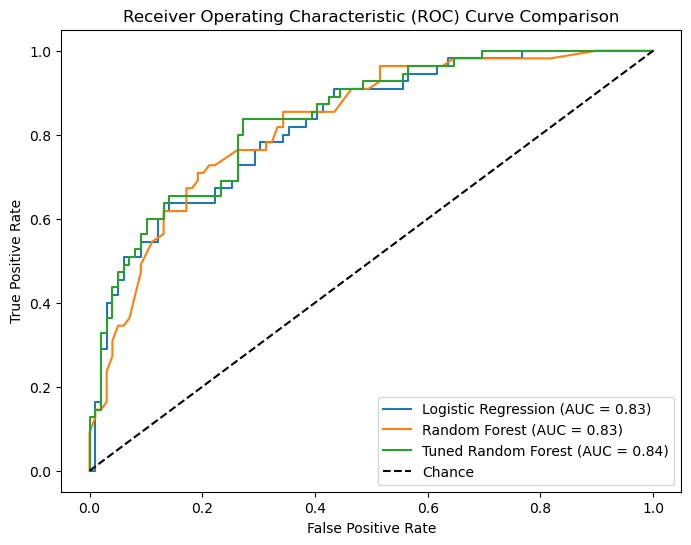

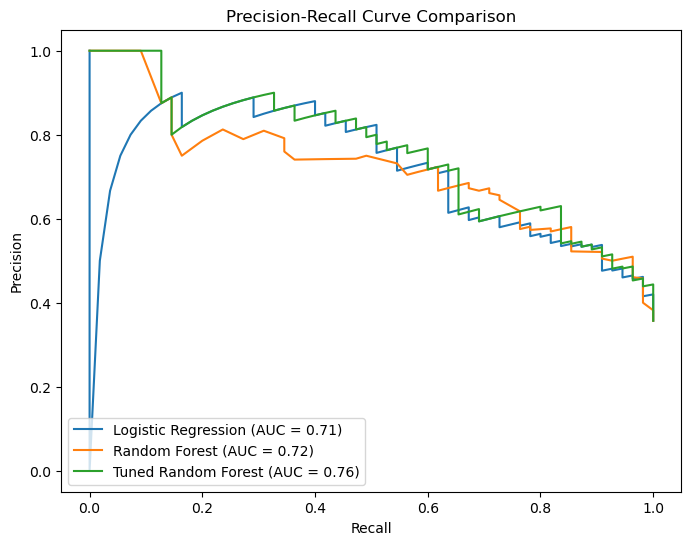

In [15]:
# Combined ROC Curve Plot
plt.figure(figsize=(8, 6))
# ROC for Logistic Regression
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, log_reg_prob)
roc_auc_log_reg = auc(fpr_log_reg, tpr_log_reg)
plt.plot(fpr_log_reg, tpr_log_reg, label=f'Logistic Regression (AUC = {roc_auc_log_reg:.2f})')

# ROC for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_prob)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')

# ROC for Tuned Random Forest
fpr_best_rf, tpr_best_rf, _ = roc_curve(y_test, best_rf_prob)
roc_auc_best_rf = auc(fpr_best_rf, tpr_best_rf)
plt.plot(fpr_best_rf, tpr_best_rf, label=f'Tuned Random Forest (AUC = {roc_auc_best_rf:.2f})')

# Plot details
plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Combined Precision-Recall Curve Plot
plt.figure(figsize=(8, 6))
# Precision-Recall for Logistic Regression
precision_log_reg, recall_log_reg, _ = precision_recall_curve(y_test, log_reg_prob)
pr_auc_log_reg = auc(recall_log_reg, precision_log_reg)
plt.plot(recall_log_reg, precision_log_reg, label=f'Logistic Regression (AUC = {pr_auc_log_reg:.2f})')

# Precision-Recall for Random Forest
precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf_prob)
pr_auc_rf = auc(recall_rf, precision_rf)
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AUC = {pr_auc_rf:.2f})')

# Precision-Recall for Tuned Random Forest
precision_best_rf, recall_best_rf, _ = precision_recall_curve(y_test, best_rf_prob)
pr_auc_best_rf = auc(recall_best_rf, precision_best_rf)
plt.plot(recall_best_rf, precision_best_rf, label=f'Tuned Random Forest (AUC = {pr_auc_best_rf:.2f})')

# Plot details
plt.title('Precision-Recall Curve Comparison')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.show()
